In [2]:
from utils import * 
import os 
from src.ggkbase import * 
import glob
import matplotlib as mpl 
from src.files import BLASTFileJSON, FASTAFile, InterProScanFileTSV, GenBankFile, fasta_get_genome_size
import subprocess
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap, to_hex
from src.metat import metat_load
from scipy.stats import gmean 

%load_ext autoreload
%autoreload 2

In [3]:
coverm_df = coverm_load('../data/coverm/all.tsv', contig_sizes=contig_sizes)
coverm_df = coverm_df[coverm_df.reactor != 'none'].copy()

metat_df = metat_load()
metat_df['genome_size'] = metat_df.length # For consistency with coverm_df.
metat_df['sample_id'] = metat_df.sample_id.str.replace('_metat', '')

# Aggregate the metat_df by genome ID. I think instead of computing the RPKM
agg_funcs = {'read_count':'sum', 'genome_size':'sum', 'library_size':'first', 'year':'first', 'location':'first', 'reactor':'first'}
metat_agg_df = metat_df.groupby(['genome_id', 'sample_id']).agg(agg_funcs).reset_index()
metat_agg_df['rpkm'] = metat_agg_df.read_count / (metat_agg_df.genome_size / 1e3) / (metat_agg_df.library_size / 1e6)
metat_agg_df['sample_id'] = metat_agg_df.sample_id.str.replace('_metat', '')

bbduk_df = bbduk_load('../data/bbduk')

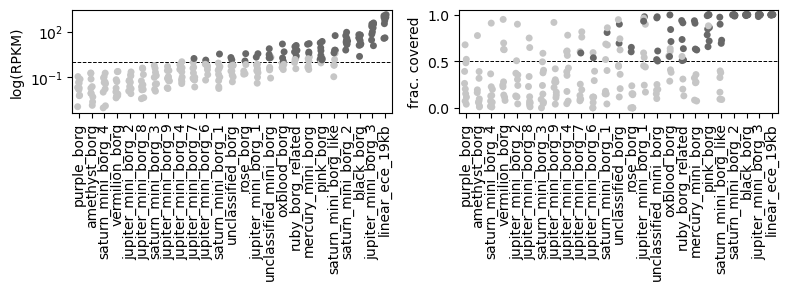

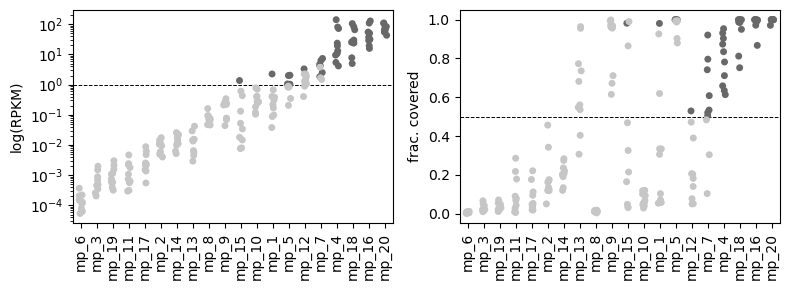

In [5]:
# Due to strain similarity, going to define some cutoffs. 
# Minimum RPKM of 0.1 and minimum genome coverage of 30&

min_rpkm = 1
min_fraction_covered_bases = 0.5

def plot_filter(figure_df:pd.DataFrame):
    figure_df['mean_rpkm'] = figure_df.genome_id.map(figure_df.groupby('genome_id').rpkm.mean())
    figure_df['meets_threshold'] = (figure_df.fraction_covered_bases > min_fraction_covered_bases) & (figure_df.rpkm > min_rpkm)
    figure_df = figure_df.sort_values('mean_rpkm')

    fig, (ax_a, ax_b) = plt.subplots(figsize=(8, 3), ncols=2)
    sns.stripplot(figure_df, x='genome_id', y='rpkm', ax=ax_a, palette='Grays', hue='meets_threshold', legend=False)
    ax_a.set_xticks(ax_a.get_xticks(), ax_a.get_xticklabels(), rotation=90)
    ax_a.set_xlabel('')
    ax_a.set_ylabel('log(RPKM)')
    ax_a.set_yscale('log')
    ax_a.axhline(min_rpkm, ls='--', color='black', lw=0.7)

    sns.stripplot(figure_df, x='genome_id', y='fraction_covered_bases', palette='Grays', ax=ax_b, hue='meets_threshold', legend=False)
    ax_b.set_xticks(ax_b.get_xticks(), ax_b.get_xticklabels(), rotation=90)
    ax_b.set_ylabel('frac. covered')
    ax_b.set_xlabel('')
    ax_b.axhline(min_fraction_covered_bases, ls='--', color='black', lw=0.7)

    fig.tight_layout()
    plt.show()

    return figure_df[figure_df.meets_threshold].genome_id.unique().tolist()

ece_genome_ids = plot_filter(coverm_df[~is_mp(coverm_df)].copy())
mp_genome_ids = plot_filter(coverm_df[is_mp(coverm_df)].copy())

# mp_genome_ids = ['mp_13']  # Methanoperedens IDs sorted by abundance. 

In [6]:
cmap_blues = LinearSegmentedColormap.from_list('blues', ['lightblue', 'steelblue'])
cmap_white_to_blue = LinearSegmentedColormap.from_list('blues', ['white', 'steelblue'])
cmap_grays = LinearSegmentedColormap.from_list('grays', ['lightgray', 'gray'])

def cmap_sample(cmap, n):
    return [to_hex(color) for color in cmap(np.linspace(0, 1, n))]

In [7]:
mp_genome_ids

['mp_15', 'mp_1', 'mp_5', 'mp_12', 'mp_7', 'mp_4', 'mp_18', 'mp_16', 'mp_20']

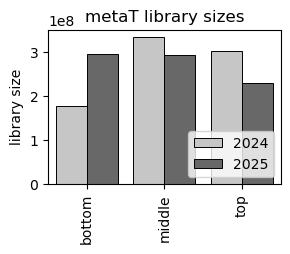

In [8]:

fig, ax = plt.subplots(figsize=(3, 2))
figure_df =  bbduk_df[(bbduk_df.reactor == 'n') & (bbduk_df.index.str.contains('metat'))].copy() # Bioreactor samples only.
figure_df = figure_df.reset_index(drop=False) 
figure_df['sample_id'] = figure_df.sample_id.str.replace('_metat', '')
figure_df['sample_id'] = figure_df.location
figure_df = figure_df.sort_values(['location', 'year'])
sns.barplot(figure_df, y='library_size', hue='year', palette='Grays', x='sample_id', color='lightgray', edgecolor='black', lw=0.7) #, hue='library_size', palette='Grays', legend=False)
ax.set_xlabel('')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
ax.set_ylabel('library size')
ax.set_title('metaT library sizes')
ax.get_legend().set_title('')
sns.move_legend(ax, loc='lower right')
plt.show()

In [9]:

# def remove_low_abundance_genomes(coverm_df, min_rpkm:float=1, min_n_samples:int=1):
#     include_genome_ids = coverm_df.groupby('genome_id').apply(lambda df : (df.rpkm > min_rpkm).sum() > min_n_samples, include_groups=False)
#     include_genome_ids = include_genome_ids[include_genome_ids].index 
#     n_genome_ids = coverm_df.genome_id.nunique()
#     print(f'remove_low_abundance_genomes: Retaining {len(include_genome_ids)} out of {n_genome_ids} targets after filtering for abundance.')
#     return coverm_df[coverm_df.genome_id.isin(include_genome_ids)].copy()


def plot_abundance(figure_df:pd.DataFrame, title=r'$\it{Methanoperedens}$ abundance', legend:bool=True, ax=None, genome_ids:list=None):

    figure_df = figure_df.sort_values(['sample_id', 'genome_id'], ascending=True)

    # figure_df = figure_df.copy()
    figure_df['year'] = [re.search(r'202\d', sample_id).group(0) for sample_id in figure_df.sample_id]
    figure_df = figure_df[figure_df.genome_id.isin(genome_ids)].copy()
    
    sample_ids = figure_df.sample_id.unique()
    n_samples = figure_df.sample_id.nunique()

    genome_ids = sorted(figure_df.genome_id.unique())
    palettes = dict()
    palettes['2024'] = dict(zip(genome_ids, cmap_sample(cmap_grays, len(genome_ids))))
    palettes['2025'] = dict(zip(genome_ids, cmap_sample(cmap_blues, len(genome_ids))))
    # print(palettes)

    bottom = np.zeros(n_samples)
    for genome_id, df in figure_df.groupby('genome_id'):
        colors = [palettes[year].get(genome_id, 'red') for year in df.year]
        heights = df.set_index('sample_id').rpkm.to_dict() # Make this robust to when some samples aren't present. 
        heights = np.array([heights.get(sample_id, 0) for sample_id in sample_ids])
        ax.bar(x=np.arange(n_samples), height=heights, bottom=bottom, label=genome_id, edgecolor='black', lw=0.7, color=colors)
        bottom += heights
    ax.set_title(title)
    ax.set_ylabel('RPKM')
    ax.set_xticks(np.arange(n_samples), labels=[sample_id.replace('_metat', '') for sample_id in sample_ids], rotation=90)

    if legend:
        handles = [Patch(edgecolor='black', linewidth=0.7, facecolor=palettes['2025'][genome_id]) for genome_id in genome_ids]
        ax.legend(handles, genome_ids)


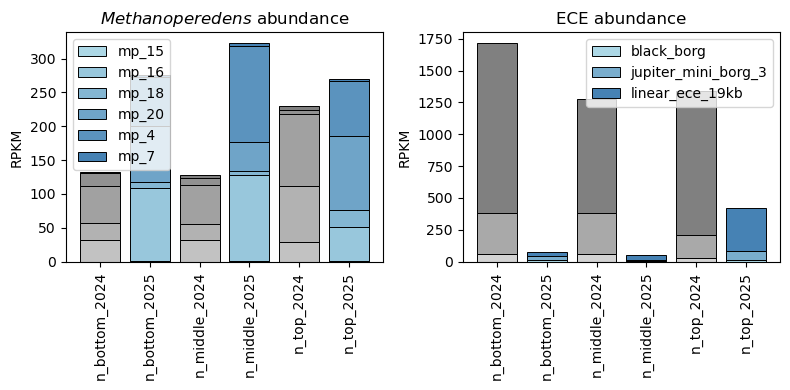

In [25]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(8, 4), ncols=2)
# mp_genome_ids = ['mp_1', 'mp_13', 'mp_15', 'mp_16', 'mp_18', 'mp_20', 'mp_4']

# plot_abundance(coverm_df.copy(), ax=ax_a, title=r'$\it{Methanoperedens}$ abundance', genome_ids=mp_genome_ids[-5:] + ['mp_15'])
# plot_abundance(coverm_df.copy(), ax=ax_b, title='ECE abundance', genome_ids=ece_genome_ids[-3:])
plot_abundance(coverm_df[(coverm_df.reactor == 'n')].copy(), ax=ax_a, title=r'$\it{Methanoperedens}$ abundance', genome_ids=mp_genome_ids[-5:] + ['mp_15'])
plot_abundance(coverm_df[(coverm_df.reactor == 'n')].copy(), ax=ax_b, title='ECE abundance', genome_ids=ece_genome_ids[-3:])

fig.tight_layout()
plt.show()

Num bases in mp_15: 2238974


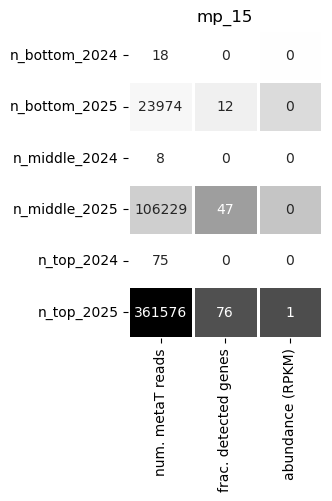

In [26]:
genome_id = 'mp_15'
# genome_id = 'black_borg'
# genome_id = 'linear_ece_19kb'
normalize = False

genome_size = coverm_df[coverm_df.genome_id == genome_id].genome_size.iloc[0]
print(f'Num bases in {genome_id}:', genome_size)

fig, ax = plt.subplots(figsize=(2.5, 4))

metat_mask = (metat_df.genome_id == genome_id) & (metat_df.reactor == 'n')
coverm_mask = (coverm_df.genome_id == genome_id) & (coverm_df.reactor == 'n')

n_samples = 6
figure_df = pd.DataFrame(index=np.arange(n_samples))
figure_df['sample_id'] = coverm_df[coverm_mask].sample_id.unique()
figure_df = figure_df.set_index('sample_id')
figure_df['read_count_metat'] = metat_df[metat_mask].groupby('sample_id').read_count.sum()
figure_df['coverage_metat'] = metat_df[metat_mask].groupby('sample_id').detected.mean() * 100

if normalize:
    figure_df['read_count_metat'] = 1e6 * figure_df.read_count_metat /  metat_df.groupby('sample_id').library_size.first()

# figure_df['read_count_coverm'] = coverm_df[coverm_mask].groupby('sample_id').read_count.first()
figure_df['abundance'] = coverm_df[coverm_mask].groupby('sample_id').rpkm.first()
# figure_df['coverage_coverm'] = coverm_df[coverm_mask].groupby('sample_id').fraction_covered_bases.first() * 100

if normalize:
    figure_df = figure_df.rename(columns={'read_count_metat':'num. metaT reads (CPM)', 'coverage_metat':'frac. detected genes', 'abundance':'abundance (RPKM)'})
else:
    figure_df = figure_df.rename(columns={'read_count_metat':'num. metaT reads', 'coverage_metat':'frac. detected genes', 'abundance':'abundance (RPKM)'})
sns.heatmap((figure_df / figure_df.sum(axis=0)), cbar=False, cmap='Grays', annot=figure_df.astype(int), fmt='d', lw=2)
# sns.heatmap((figure_df - figure_df.mean(axis=0)) / figure_df.std(axis=0), cbar=False, cmap='Grays', annot=figure_df.astype(int), fmt='d')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title(genome_id)
plt.show()


In [12]:
coverm_df[coverm_mask]

,sample_id,genome_id,variance,mean,trimmed_mean,covered_bases,read_count,genome_size,rpkm,tpm,fraction_covered_bases,location,reactor,year
595,n_bottom_2024,linear_ece_19kb,762.67883,102.183960,104.244736,19040,7750,19040,1334.195900,70505.5800,1.000000,bottom,n,2024
640,n_bottom_2025,linear_ece_19kb,28.05439,9.734992,9.418127,18947,811,19040,36.860455,3317.2327,0.995116,bottom,n,2025
685,n_middle_2024,linear_ece_19kb,2888.55520,188.533620,191.530700,19040,14308,19040,897.501200,52677.2400,1.000000,middle,n,2024
730,n_middle_2025,linear_ece_19kb,202.01376,36.119480,35.429540,19023,3003,19040,39.978138,8603.2050,0.999107,middle,n,2025
775,n_top_2024,linear_ece_19kb,8433.29500,327.400900,334.033170,19040,24812,19040,1128.865700,95361.4600,1.000000,top,n,2024
820,n_top_2025,linear_ece_19kb,454.81964,76.705505,77.099870,19039,6119,19040,339.980800,40603.0630,0.999947,top,n,2025


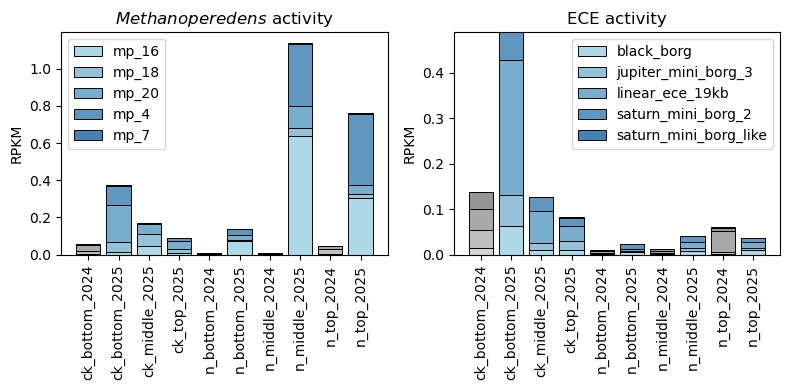

In [13]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(8, 4), ncols=2)

plot_abundance(metat_agg_df, ax=ax_a, title=r'$\it{Methanoperedens}$ activity', genome_ids=mp_genome_ids[-5:])
plot_abundance(metat_agg_df, ax=ax_b, title='ECE activity', genome_ids=ece_genome_ids[-5:])
# plot_abundance(metat_agg_df[(metat_agg_df.reactor == 'n')], ax=ax_a, title=r'$\it{Methanoperedens}$ activity', genome_ids=mp_genome_ids[-5:])
# plot_abundance(metat_agg_df[(metat_agg_df.reactor == 'n')], ax=ax_b, title='ECE activity', genome_ids=ece_genome_ids[-5:])

fig.tight_layout()
plt.show()

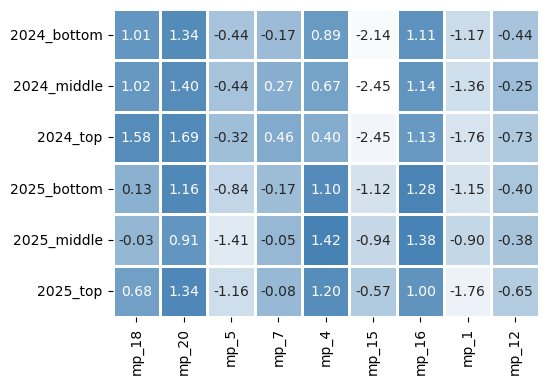

In [14]:

reformat_sample_id = lambda row : f'{row.year}_{row.location}'

def get_clr_normalization(df):
    df = df.copy()
    df['geometric_mean'] = df.sample_id.map(df.groupby('sample_id').apply(lambda df_ : scipy.stats.gmean(df_.rpkm), include_groups=False))
    df['rpkm_clr_normalized'] = np.log10(df.rpkm) - np.log10(df.geometric_mean)
    return df

def plot_composition(figure_df:pd.DataFrame, genome_ids=mp_genome_ids):

    figure_df = figure_df[(figure_df.reactor == 'n') & figure_df.genome_id.isin(genome_ids)].copy()
    figure_df = get_clr_normalization(figure_df)
    figure_df['sample_id'] = [reformat_sample_id(row) for row in figure_df.itertuples()] 
    figure_df = figure_df.sort_values('sample_id')

    fig, ax = plt.subplots(figsize=(5.5, 4))
    figure_df = figure_df.pivot(index='sample_id', columns='genome_id', values='rpkm_clr_normalized')
    figure_df = figure_df[genome_ids]
    # NOTE: None indexing adds a dimension. 
    # sns.heatmap(figure_df, cmap=cmap_white_to_blue, annot=True, cbar=False, lw=1, fmt='.2f')
    # sns.heatmap((figure_df - figure_df.mean(axis=0).values[None, :]) / figure_df.std(axis=0).values[None, :], lw=1, cmap=cmap_white_to_blue, annot=figure_df, cbar=False, fmt='.2f', ax=ax)
    sns.heatmap((figure_df - figure_df.mean(axis=1).values[:, None]) / figure_df.std(axis=1).values[:, None], lw=1, cmap=cmap_white_to_blue, annot=figure_df, cbar=False, fmt='.2f', ax=ax)
    ax.set_ylabel('')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')
    plt.show()

mp_genome_ids_ordered = ['mp_18', 'mp_20', 'mp_5', 'mp_7', 'mp_4', 'mp_15', 'mp_16', 'mp_1', 'mp_12']
plot_composition(coverm_df, genome_ids=mp_genome_ids_ordered)
# plot_composition(metat_agg_df)

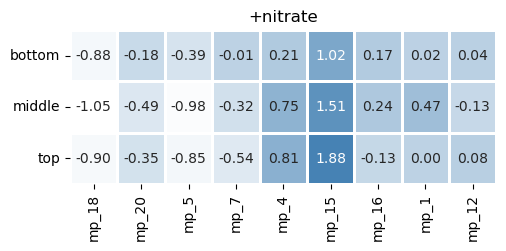

In [15]:
def plot_composition_change(figure_df:pd.DataFrame, genome_ids=mp_genome_ids, title='+nitrate'):

    figure_df = figure_df[(figure_df.reactor == 'n') & figure_df.genome_id.isin(genome_ids)].copy()
    figure_df = get_clr_normalization(figure_df)
    figure_df = figure_df.sort_values('location')

    figure_df_2024 = figure_df[figure_df.year == '2024'].copy().pivot(index='location', columns='genome_id', values='rpkm_clr_normalized')
    figure_df_2025 = figure_df[figure_df.year == '2025'].copy().pivot(index='location', columns='genome_id', values='rpkm_clr_normalized')
    figure_df = figure_df_2025 - figure_df_2024


    fig, ax = plt.subplots(figsize=(5.5, 2))
    figure_df = figure_df
    figure_df = figure_df[genome_ids]
    sns.heatmap(figure_df, cmap=cmap_white_to_blue, annot=True, cbar=False, lw=1, fmt='.2f')
    # sns.heatmap((figure_df - figure_df.mean(axis=0).values[None, :]) / figure_df.std(axis=0).values[None, :], cmap=cmap_white_to_blue, annot=figure_df, cbar=False, fmt='.2f', ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_title(title)
    plt.show()


mp_genome_ids_ordered = ['mp_18', 'mp_20', 'mp_5', 'mp_7', 'mp_4', 'mp_15', 'mp_16', 'mp_1', 'mp_12']
plot_composition_change(coverm_df, genome_ids=mp_genome_ids_ordered)

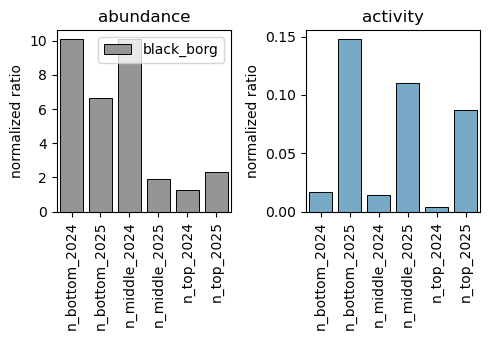

In [16]:
# What if we assume that mp_13 is the only host? What happens to the ratio?


# host_genome_ids = ['mp_18']
# ece_genome_ids = ['black_borg','saturn_mini_borg_2', 'jupiter_mini_borg_3' ]


def plot_ratios(figure_df, ax=None, ece_genome_ids=['linear_ece_19kb'], host_genome_ids=None, legend:bool=True, title:str='', palette:str=None):
    host_read_counts = coverm_df[coverm_df.genome_id.isin(host_genome_ids)].groupby('sample_id').read_count.sum().to_dict()
    host_genome_size = figure_df[figure_df.genome_id.isin(host_genome_ids)].drop_duplicates('genome_id').genome_size.sum()

    figure_df = figure_df[figure_df.genome_id.isin(ece_genome_ids)].copy()
    figure_df['host_read_count'] = figure_df.sample_id.map(host_read_counts)
    figure_df['read_count_ratio'] = (figure_df.read_count / figure_df.genome_size) / (figure_df.host_read_count / host_genome_size)
    figure_df = figure_df.sort_values(['reactor', 'location', 'year'])

    sns.barplot(figure_df, x='sample_id', y='read_count_ratio', lw=0.7, edgecolor='black', palette=palette, hue='genome_id', ax=ax, legend=legend)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('normalized ratio')
    # ax.set_ylabel('read count ratio')
    ax.set_xlabel('')
    if legend:
        ax.get_legend().set_title('')
    ax.set_title(title)

kwargs = dict()
# kwargs['host_genome_ids'] = ['mp_18', 'mp_5',]
kwargs['host_genome_ids'] = ['mp_18'] 
kwargs['ece_genome_ids'] = ['black_borg']

fig, (ax_a, ax_b) = plt.subplots(figsize=(5, 3.5), ncols=2)
plot_ratios(coverm_df[coverm_df.reactor == 'n'].copy(), ax=ax_a, title='abundance', palette='Grays', **kwargs)
plot_ratios(metat_agg_df[metat_agg_df.reactor == 'n'].copy(), ax=ax_b, legend=False, title='activity', palette='Blues', **kwargs)
# ax_b.set_ylim(ymax=5)
# fig.suptitle(f'candidate hosts: {', '.join(host_genome_ids)}')
fig.tight_layout()
plt.show()

In [17]:
print(mp_genome_ids)

['mp_15', 'mp_1', 'mp_5', 'mp_12', 'mp_7', 'mp_4', 'mp_18', 'mp_16', 'mp_20']


In [18]:
# figure_df = metat_df.copy()
# figure_df = figure_df[figure_df.genome_id.isin(mp_genome_ids)].copy()
# figure_df = figure_df.groupby(['genome_id', 'sample_id']).agg({'read_count':'sum', 'genome_size':'sum', 'library_size':'first'}).reset_index()
# figure_df['rpkm'] = figure_df.read_count / (figure_df.genome_size / 1e3) / (figure_df.library_size / 1e6)
# figure_df = get_clr_normalization(figure_df)
# figure_df = figure_df[figure_df.sample_id.str.startswith('n_')].copy()
# figure_df['sample_id'] = figure_df.sample_id.str.replace('_metat', '')
# figure_df['sample_id'] = [f'{sample_id.split('_')[-1]}_{sample_id.split('_')[1]}' for sample_id in figure_df.sample_id]
# figure_df = figure_df.sort_values('sample_id')

# fig, ax = plt.subplots(figsize=(4, 4))
# figure_df = figure_df.pivot(index='sample_id', columns='genome_id', values='rpkm_clr_normalized')
# sns.heatmap(figure_df, cmap='Grays', annot=True, cbar=False)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_title('control')
# plt.show()